# Graphing Duke PhD Committee Interdisciplinary Connections

#### Imports and other setup

set_node_attributes was not working for me with networkx 2.0 [see issue here](https://github.com/USEPA/WNTR/issues/29), so downgraded to 1.11 to get it running.

In [1]:
import math
from itertools import cycle
import pandas as pd
import numpy as np
import networkx as nx
import os
from visJS2jupyter import visJS_module
import community
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from operator import itemgetter
import operator
from ast import literal_eval
from datetime import datetime

# For display purposes
%matplotlib inline
# plt.switch_backend('TkAgg')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 800)

#### Setup paths, "global" variables, etc

In [2]:
primary_only = False
output_path = './output'
debug = False
my_nrows = None # run on all rows

if primary_only:
    edges_path = '../outputs/apt_primary/edges_primary_appointments.csv'
    orgs_path = '../outputs/apt_primary/org_names_primary_appointments.csv'
else:
    edges_path = '../outputs/apt_all/edges_all_appointments.csv'
    orgs_path = '../outputs/apt_all/org_names_all_appointments.csv'

In [3]:
########################################################
# Define a function to create the output dir, if it already exists don't crash, otherwise raise an exception
# Adapted from A-B-B's response to http://stackoverflow.com/questions/273192/in-python-check-if-a-directory-exists-and-create-it-if-necessary
# Note in python 3.4+ 'os.makedirs(output_path, exist_ok=True)' would handle all of this...
def make_path(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise Exception('Problem creating output dir %s !!!\nA file with the same name probably already exists, please fix the conflict and run again.' % output_path)

#### Define custom color functions for good discrete node colors, min / max edge colors  
It has to be in this string format for visJS2jupyter. See [`return_node_to_color()`](https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py#L558) and [`return_edge_to_color()`](https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py#L605) in [visJS_module.py](https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py) for the normal methods  

In [4]:
def my_node_to_color(G,field_to_map='degree'):
    nodes_with_data = [(n[0], max(n[1][field_to_map], 0)) for n in G.nodes(data=True)]

    nsteps=20
    color_order=[0,2,4,6,8,10,12,14,16,18,1,3,5,7,9,11,13,15,17,19]
    cmap=plt.get_cmap("tab20")
    alpha = 1.0
    
    color_list_raw = cmap(np.linspace(0, 1, nsteps)) 
  
    nodes,data = zip(*nodes_with_data)
    data = [color_order[d] for d in data]
    nodes_with_data = zip(nodes,data)

    node_to_mapField = dict(nodes_with_data)
    color_list = [color_list_raw[node_to_mapField[d]] for d in G.nodes()]
    
    color_list = [(int(256*c[0]),int(256*c[1]),int(256*c[2]),alpha) for c in color_list]
    node_to_color = dict(zip(list(G.nodes()),['rgba'+str(c) for c in color_list]))

    return node_to_color

In [5]:
def my_edge_to_color(G,field_to_map='degree',cmap=plt.cm.jet,alpha = 1.0,color_vals_transform = None,ceil_val=10,
                         color_max_frac = 1.0,color_min_frac = 0.0):
    # check whether it is a multigraph or not
    if (str(type(G)) == '<class \'networkx.classes.multigraph.MultiGraph\'>'):
        G_edges = G.edges(keys = True, data=True)
        edges_with_data = [(e[0],e[1],e[2],e[3][field_to_map]) for e in G_edges]
        edges1,edges2,edges3, data = zip(*edges_with_data)
    else:
        G_edges = G.edges(data=True)
        edges_with_data = [(e[0],e[1],e[2][field_to_map]) for e in G_edges]
        edges1,edges2,data = zip(*edges_with_data)
    # perform data transformations if necessaary
    if color_vals_transform == 'log':
        nonzero_list = [d for d in data if d>(10**-18)]
        if not nonzero_list:
            data = [1 for d in data]
        else:
            min_dn0 = min([d for d in data if d>(10**-18)])
            data = [np.log(max(d,min_dn0)) for d in data]  # set the zero d values to minimum non0 value
            data = [(d-np.min(data)) for d in data] # shift so we don't have any negative values
    elif color_vals_transform == 'sqrt':
        data = [np.sqrt(d) for d in data]
    elif color_vals_transform == 'ceil':
        data = [max(d,ceil_val) for d in data]
    # check whether it is a multigraph or not
    if (str(type(G)) == '<class \'networkx.classes.multigraph.MultiGraph\'>'):
        edges_with_data = zip(zip(edges1,edges2,edges3),data)
        G_edges = G.edges(keys = True)
    else:
        G_edges = G.edges()
        edges_with_data = zip(zip(edges1,edges2),data)
    
    color_to_mult = 256*(color_max_frac-color_min_frac)
    color_to_add = 256*color_min_frac

    edge_to_mapField = dict(edges_with_data)
    color_list = [np.multiply(cmap(int(float(edge_to_mapField[d])/np.max(list(edge_to_mapField.values()))*color_to_mult+color_to_add)),256) for d in G_edges]
    color_list = [(int(c[0]),int(c[1]),int(c[2]),alpha) for c in color_list]
    
    edge_to_color = dict(zip(list(G_edges),['rgba'+str(c) for c in color_list]))
    return edge_to_color


Define function to convert visJS text colors to regular plt colot tuples

In [6]:
def color_str_to_tuple(color_str):
    color_str = color_str.replace('rgba','')
    color_tuple_raw = literal_eval(color_str)
    color_tuple = [x / 256.0 for x in color_tuple_raw[:3]]
    color_tuple.append(color_tuple_raw[3])
    return color_tuple

Convert between visJS and matplotlib symbol names

In [7]:
visJS_to_mpl_symbol={
'dot':'o',
'square':'s',
'triangleDown':'v',
'triangle':'^',
'diamond':'D',
'star':'*'
}

#### Read in human readable names, create usable dicts / symbols of them

In [8]:
df_org = pd.read_csv(orgs_path, dtype={
'ORGANIZATIONAL_UNIT': int,
'SCHOOL_NAME': object,
'ORG_DISPLAY_NAME': object
})
df_org_index = df_org.set_index('ORGANIZATIONAL_UNIT')

df_org_names = df_org_index[['ORG_DISPLAY_NAME']]
org_names = df_org_names.to_dict()['ORG_DISPLAY_NAME']

df_school_names = df_org_index[['SCHOOL_NAME']]
school_names = df_school_names.to_dict()['SCHOOL_NAME']

# Autogenerate
#school_names_list = list(df_org_index['SCHOOL_NAME'].unique())
#symbol_list = ["dot", "diamond", "star", "triangle", "triangleDown", "square"]
#school_symbols = {k: v for k, v in zip(school_names_list, cycle(symbol_list))}

# just hard code to group up rarer ones
school_symbols={
 'Trinity College of Arts & Sciences': 'dot',
 'Pratt School of Engineering': 'square',
 'School of Medicine': 'triangle',
 "Institutes and Provost's Academic Units": 'triangleDown',
 'Nicholas School of the Environment': 'diamond',
 'School of Nursing': 'star',
 'Sanford School of Public Policy': 'star',
 'Divinity School': 'star',
 'Duke Law School': 'star',
 'Fuqua School of Business': 'star',
}

In [9]:
leg_objects = []
for key, value in sorted(school_symbols.items(), key=operator.itemgetter(1)):
    leg_objects.append(plt.Line2D([0],[0],ls='None',marker=visJS_to_mpl_symbol[value],ms=7.0,label=key,c='black'))

In [10]:
# stand alone legend
#plt.figure(figsize=(9, 4), dpi=120, facecolor='w', edgecolor='k')
#plt.axis("off")
#school_leg = plt.legend(leg_objects, [ob.get_label() for ob in leg_objects], fontsize='large', borderaxespad=0.0)
#school_leg.get_frame().set_edgecolor('white')
#school_leg.get_frame().set_facecolor('white')
#plt.show()

#### Read in edges from csv

In [11]:
if debug:
    if(my_nrows is not None): print "Reading first %d rows of %s" % (my_nrows, edges_path)
    else: print "Reading all rows of %s" % (edges_path)
# need to specify dtypes manually when reading many rows...
# otherwise pandas wants to try to load all the rows into memory before inferring the dtype and you get a warning
df_edges = pd.read_csv(edges_path, dtype={
'Date': object,
'n1': int,
'n2': int
} , nrows=my_nrows)
df_edges['Date'] = pd.to_datetime(df_edges['Date'],format='%Y-%m-%d')

#### Build graph G up explicitly, edge by edge. This way we can get the weights correct. Annotate nodes with the total weights from all their edges

In [12]:
def build_G(df):
    G = nx.Graph()
    default_weight = 1.0
    for index, row in df.iterrows():
        n1 = row['n1']
        n2 = row['n2']
        if G.has_edge(n1,n2):
            G[n1][n2]['weight'] += default_weight
        else:
            G.add_edge(n1,n2, weight=default_weight)

    total_weight_dict = {}
    for node in G.nodes():
        total_weight = 0.0
        for edge in G.edges(node,data=True):
            total_weight += edge[2]['weight']
        total_weight_dict[node] = total_weight
    
    nx.set_node_attributes(G, 'total_weight', total_weight_dict)

    return G

G_all = build_G(df_edges)

### Create positions using the Fruchterman-Reingold force-directed / spring algorithm

In [13]:
spring_pos = nx.spring_layout(G_all,k=4/math.sqrt(nx.number_of_nodes(G_all))) # 1/sqrt(n) is the default spacing par

### Create partitions / communities using the Louvain Method

In [14]:
parts = community.best_partition(G_all, weight='weight')
nx.set_node_attributes(G_all, 'parts', parts) 

### Draw interactive graph!

In [15]:
nodes = G_all.nodes()

node_to_color = my_node_to_color(G_all,field_to_map='parts')

nodes_to_shape = {}
for n in nodes:
    nodes_to_shape[n] = school_symbols[school_names[n]]
nx.set_node_attributes(G_all, 'symbol', nodes_to_shape)

nodes_dict = [{"id":n,
               "title":("%s (%s)" % (org_names[n],school_names[n])),
               "x":spring_pos[n][0]*1000,
               "y":(1-spring_pos[n][1])*1000,
               "color":node_to_color[n], 
               "node_shape":G_all.node[n]['symbol'],
               "node_size":G_all.node[n]['total_weight']
              } for n in nodes]
node_map = dict(zip(nodes,range(len(nodes)))) # map to indices for source/target in edges

In [16]:
edges_list = list(G_all.edges())
edge_to_color = my_edge_to_color(G_all,field_to_map='weight',cmap=plt.cm.Greys,alpha = 1,color_vals_transform='log',color_max_frac = 1.0,color_min_frac = 0.15)
edges_dict = [{"source":node_map[edges_list[i][0]],
               "target":node_map[edges_list[i][1]],
               "title":("%s - %s" % (org_names[edges_list[i][0]],org_names[edges_list[i][1]])),
               "color":edge_to_color[edges_list[i]] 
              }for i in range(len(edges_list))]

In [17]:
visJS_module.visjs_network(nodes_dict, edges_dict,
                           node_size_field='node_size',
                           node_size_transform='Math.log',
                           node_size_multiplier=2,
                           node_font_size=0,
                           edge_width=9,
                           edge_title_field="title",
                           graph_width = 900,
                           graph_height = 700,
                           tooltip_delay = 0, graph_id = 0, config_enabled=False)

### List the members of the communities

In [18]:
df_communities = pd.DataFrame(parts.items(), columns=['ORGANIZATIONAL_UNIT', 'Community'])

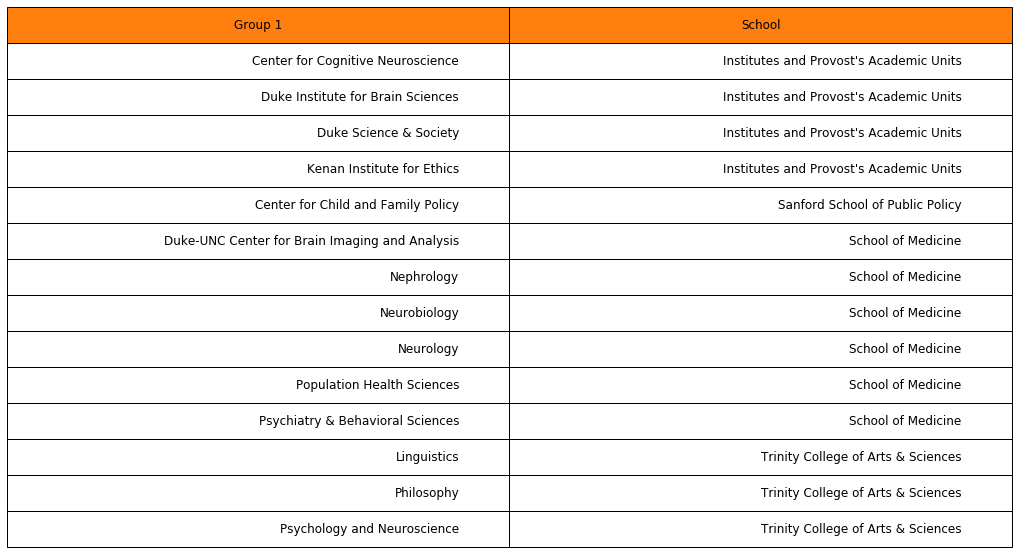

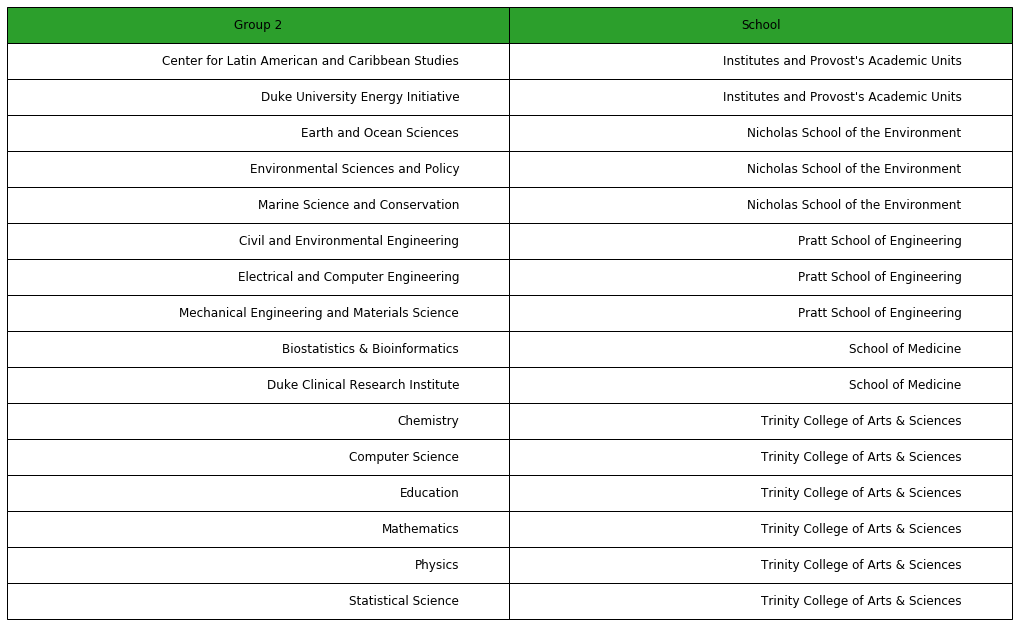

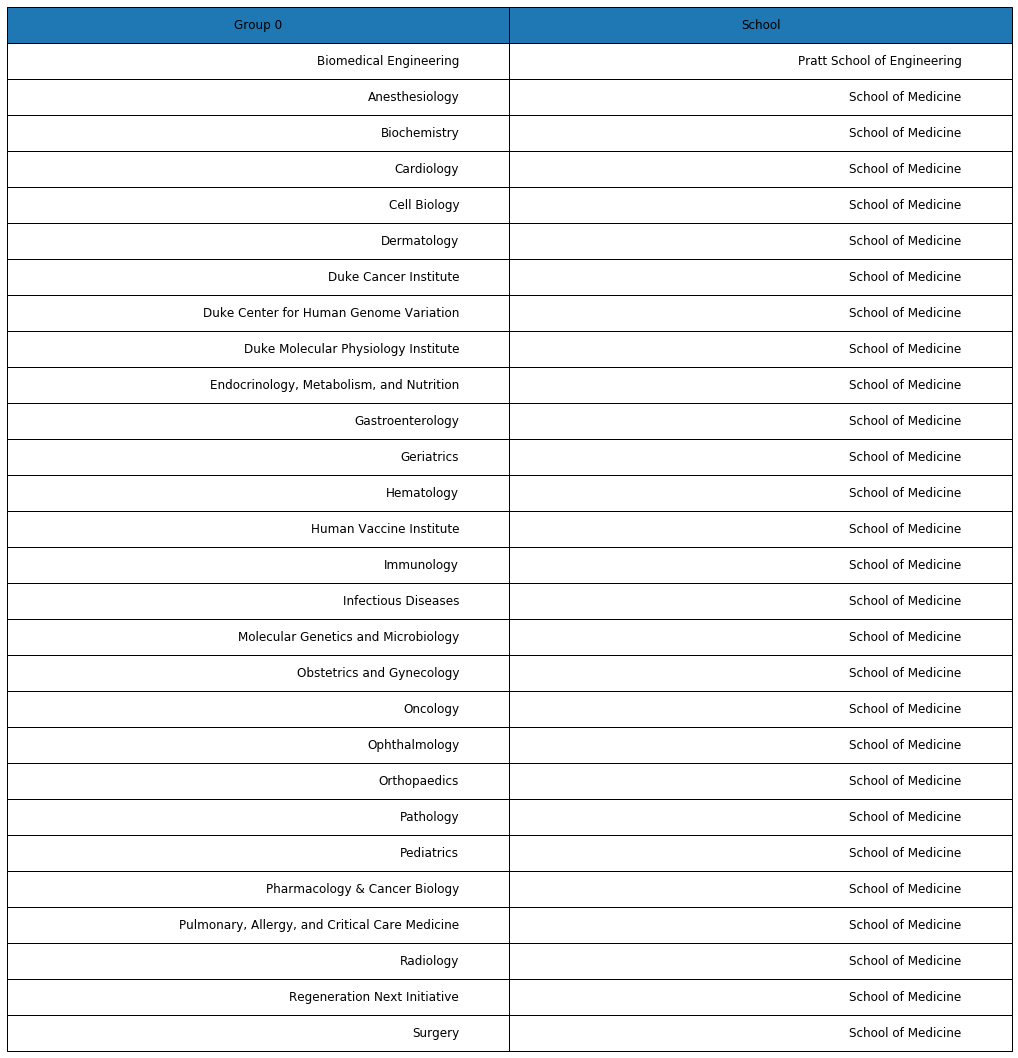

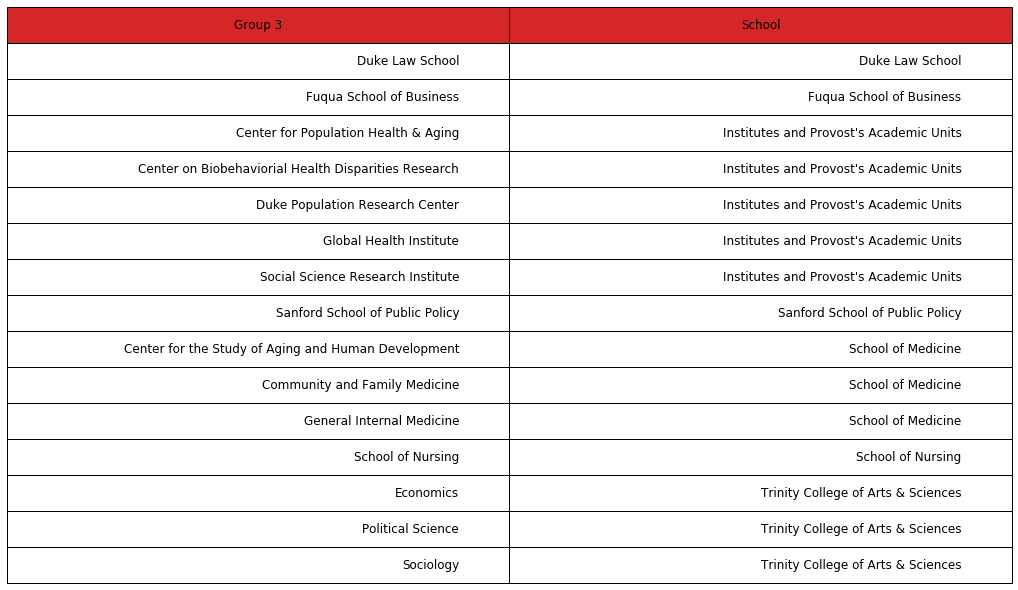

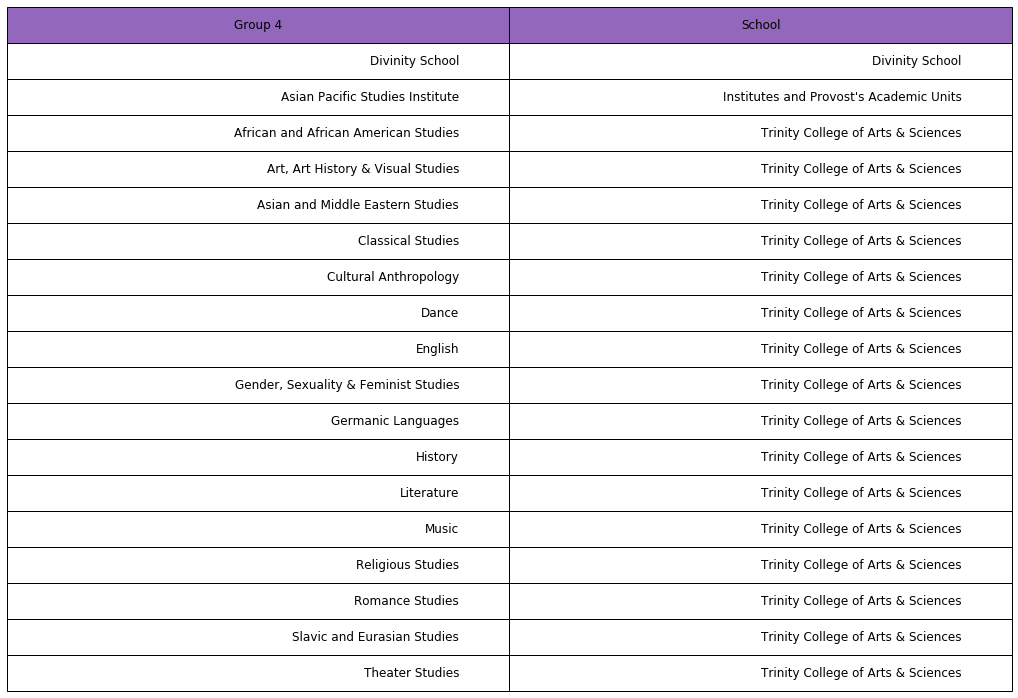

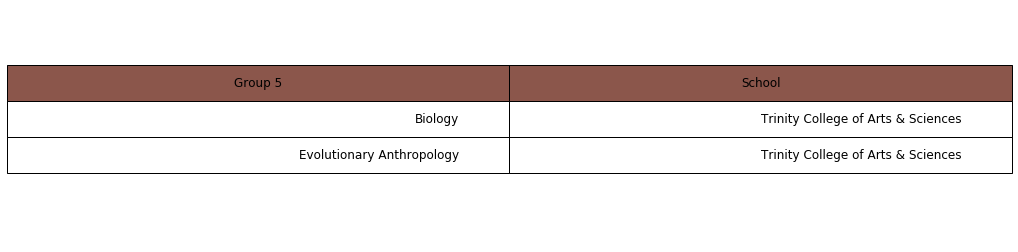

In [19]:
## As matplotlib tables, with color coded headers
for community in df_communities.Community.unique():
    df_community = df_communities[df_communities['Community']==community]
    cell_text = []
    first_n = -1
    for n in list(df_community['ORGANIZATIONAL_UNIT']):
        # cell_text.append([("%s - %s" % (org_names[n],school_names[n]))])
        cell_text.append([org_names[n], school_names[n]])
        if first_n == -1: first_n = n

    cell_text.sort(key = operator.itemgetter(1, 0))

    color_tuple = color_str_to_tuple(node_to_color[first_n])

    plt.axis('off')
    the_table = plt.table(cellText=cell_text,colLabels=[("Group %d" % community),"School"],
              colColours=[color_tuple,color_tuple],
              loc='center')
    the_table.scale(3,3)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    plt.show()

### Plot static network graphs

In [20]:
def plot_graph(this_G,display_annotations=True,label_text="",show_plot=False,m_path=None,filename=None):
    figname = "graph"
    if filename is not None: figname += '_'+filename
    fig = plt.figure(figname)
    fig.set_size_inches(13, 8) # x, y inches

    if display_annotations:
        gs = gridspec.GridSpec(1, 2, width_ratios=[2.8, 1]) 
        ax_left = plt.subplot(gs[0])
    else:
        ax_left = plt.subplot(111)
    ax_left.axis("off")
    ax_left.margins(0,0)

    for shape in set((shape[1]["symbol"] for shape in this_G.nodes(data = True))):
        node_list = [node[0] for node in filter(lambda x: x[1]["symbol"]==shape,this_G.nodes(data = True))]
        nx.draw_networkx_nodes(this_G,ax=ax_left, pos=spring_pos,nodelist=node_list,
                               node_color=[color_str_to_tuple(node_to_color[n]) for n in node_list],
                               node_size=[20*math.log(this_G.node[n]['total_weight']) for n in node_list],
                               node_shape=visJS_to_mpl_symbol[shape]
                              )

    this_edge_to_color = my_edge_to_color(this_G,field_to_map='weight',cmap=plt.cm.Greys,alpha = 1,color_vals_transform='log',color_max_frac = 1.0,color_min_frac = 0.15)
    nx.draw_networkx_edges(this_G,spring_pos,ax=ax_left,width=4,edge_color=[color_str_to_tuple(this_edge_to_color[e]) for e in list(this_G.edges())])

    if display_annotations:
        ax_right = plt.subplot(gs[1])
        ax_right.axis("off")
        ax_right.margins(0,0)

        school_leg = plt.legend(leg_objects, [ob.get_label() for ob in leg_objects], fontsize='large', borderaxespad=0.0)
        school_leg.get_frame().set_edgecolor('white')
        school_leg.get_frame().set_facecolor('white')

        ann_text = "Node Color: Louvain Groupings\nNode Size: log(Total Connections)\nEdge Color: log(Connections)\n\n"
        if label_text is not None: ann_text += label_text
        plt.figtext(0.85, 0.5, ann_text, size='large', ha='center')

    fig.tight_layout()
    if (m_path is not None) and (filename is not None):
        make_path(m_path)
        # fig.savefig(m_path+'/'+filename'.png', dpi=120)
        fig.savefig(m_path+'/'+filename+'.pdf', format="pdf")
    
    if show_plot:
        plt.show()
        
    fig.clf()

#### Print graph of all dates for poster

/home/mepland/.virtualenvs/pandas/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/mepland/.virtualenvs/pandas/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/home/mepland/.virtualenvs/pandas/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):


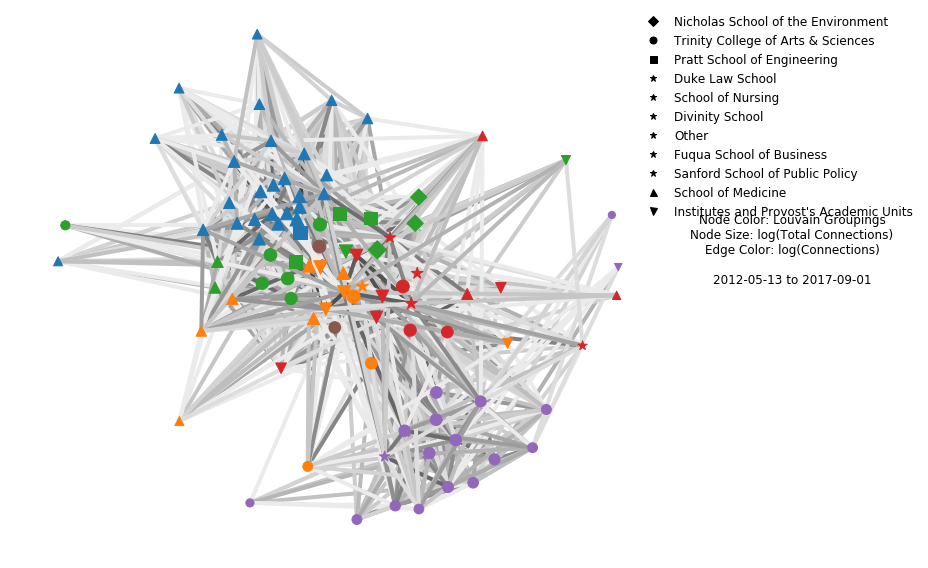

In [21]:
date_min_all = min(df_edges.Date).strftime('%Y-%m-%d')
date_max_all = max(df_edges.Date).strftime('%Y-%m-%d')
all_date_str = ("%s to %s" % (date_min_all, date_max_all))

plot_graph(G_all,False,None,False,output_path,"network_all")
plot_graph(G_all,True,all_date_str,True,output_path,"network_all_annotated")

## Start date binned results

In [22]:
print "Date min: %s" % (min(df_edges.Date))
print "Date max: %s" % (max(df_edges.Date))

date_bins = ['2012-5-1', '2013-8-26','2014-8-25','2015-8-24','2016-8-29','2017-10-1']
print "Date binning:"
print date_bins

Date min: 2012-05-13 00:00:00
Date max: 2017-09-01 00:00:00
Date binning:
['2012-5-1', '2013-8-26', '2014-8-25', '2015-8-24', '2016-8-29', '2017-10-1']


In [25]:
G_total_weight_all = 0
for e in G_all.edges(data=True):
    G_total_weight_all += e[2]['weight']
node_weights_all=[G_all.node[n]['total_weight'] for n in G_all.nodes()]
node_weight_q75_all, node_weight_q25_all = np.percentile(node_weights_all, [75 ,25])

G_weight_mean_all = float(G_total_weight_all)/float(nx.number_of_nodes(G_all))
node_weight_median_all = np.median(node_weights_all)
node_weight_iqr_all = node_weight_q75_all - node_weight_q25_all
 
G_binned = [[G_all,date_min_all,date_max_all,G_total_weight_all,G_weight_mean_all,node_weight_median_all,node_weight_iqr_all]]

year_ints = [-1] # all
for nbin in range(len(date_bins)-1):
    date_min = date_bins[nbin]
    date_max = date_bins[nbin+1]

    df_edges_bin = df_edges.loc[(date_min <= df_edges['Date']) & (df_edges['Date'] < date_max)]

    # print "For %s to %s, N rows used = %d" % (date_min, date_max, len(df_edges_bin.index))
    
    G_bin = build_G(df_edges_bin)
    
    parts_bin = {} # lol
    for node in G_bin.nodes(): parts_bin[node]=parts[node]
    nx.set_node_attributes(G_bin, 'parts', parts_bin)

    nodes_to_shape_bin = {}
    for node in G_bin.nodes(): nodes_to_shape_bin[node]=nodes_to_shape[node]
    nx.set_node_attributes(G_bin, 'symbol', nodes_to_shape_bin)

    G_total_weight = 0
    for e in G_bin.edges(data=True):
        G_total_weight += e[2]['weight']

    node_weights=[G_bin.node[n]['total_weight'] for n in G_bin.nodes()]
    node_weight_q75, node_weight_q25 = np.percentile(node_weights, [75 ,25])

    G_weight_mean = float(G_total_weight)/float(nx.number_of_nodes(G_bin))
    node_weight_median = np.median(node_weights)
    node_weight_iqr = node_weight_q75 - node_weight_q25
  
    G_binned.append([G_bin,date_min,date_max,G_total_weight,G_weight_mean,node_weight_median,node_weight_iqr])
    year_ints.append(datetime.strptime(date_bins[nbin], '%Y-%m-%d').year)

### Stats, Centrality, and Network Plot

In [26]:
# print all plots to file
for nbin in range(len(G_binned)):
    date_min = G_binned[nbin][1]
    date_max = G_binned[nbin][2]
    date_str = ("%s to %s" % (date_min, date_max))
    date_file_name = ("%s_to_%s" % (date_min, date_max))
    plot_graph(G_binned[nbin][0],True,date_str,False,output_path+"/time_binned/networks/","network_"+date_file_name)

In [27]:
def text_info(nbin):
    this_G = G_binned[nbin][0]
    date_min = G_binned[nbin][1]
    date_max = G_binned[nbin][2]
    date_str = ("%s to %s (%d)" % (date_min, date_max, year_ints[nbin]))
    
    print "For %s" % (date_str)
    
    print "\nNumber of nodes: %d" % nx.number_of_nodes(this_G)
    print "Number of edges: %d" % nx.number_of_edges(this_G)
    print "Total weight: %d" % G_binned[nbin][3]

    print "\nDensity: %.4f" % (nx.density(this_G))
    print "Triadic closure: %.4f" % (nx.transitivity(this_G))
    print "Diameter: %d" % (nx.diameter(this_G))
    
    degree_dict = this_G.degree(this_G.nodes())
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print "\nTop 5% of nodes by degree:"
    for d in sorted_degree[:int(0.05*len(sorted_degree))]:
        print "%d, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])
        
    eigenvector_dict = nx.eigenvector_centrality(this_G)
    sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)
    print "\nTop 5% of nodes by eigenvector:"
    for d in sorted_eigenvector[:int(0.05*len(sorted_eigenvector))]:
        print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])
        
    betweenness_dict = nx.betweenness_centrality(this_G)
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    print "\nTop 5% of nodes by betweenness:"
    for d in sorted_betweenness[:int(0.05*len(sorted_betweenness))]:
        print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])
        
    plot_graph(this_G,True,date_str,True)

In [28]:
interact(text_info, nbin=widgets.IntSlider(description='Time Bin:',min=0,max=len(G_binned)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description=u'Time Bin:', max=5), Output()), _dom_classes=('widget-interact',))

### Interdisciplinary Fraction Calculation - DEV

In [29]:
all_rows_list = []
for nbin in range(len(G_binned)):
    this_G = G_binned[nbin][0]
    year = year_ints[nbin]
    
    G_total_weight = G_binned[nbin][3]
    G_weight_mean =  G_binned[nbin][4]
    node_weight_median =  G_binned[nbin][5]
    node_weight_iqr =  G_binned[nbin][6]

    for node in this_G.nodes():
        node_interdis_weight = 0.0
        node_total_weight = 0.0
        for edge in this_G.edges(node,data=True):
            weight = edge[2]['weight']
            node_total_weight += weight
            if edge[0] != edge[1]:
                node_interdis_weight += weight
    
        this_row = {'year':year,
                    'node':node,
                    'org_name':org_names[node],
                    'school_name':school_names[node],
                    'interdis_frac':float(node_interdis_weight)/float(node_total_weight),
                    'node_total_weight':node_total_weight,
                    'G_total_weight':G_total_weight,
                    'G_weight_mean':G_weight_mean,
                    'node_weight_median':node_weight_median,
                    'node_weight_iqr':node_weight_iqr
                   }
        all_rows_list.append(this_row)

df_fracs = pd.DataFrame(all_rows_list)

In [30]:
schools_to_plot=['Trinity College of Arts & Sciences','School of Medicine',"Institutes and Provost's Academic Units"]

# top n orgs by total weight on node, over all years
top_n_orgs_to_plot = 10

df_fracs['cut'] = df_fracs.node_weight_median - 0.1*df_fracs.node_weight_iqr
df_fracs = df_fracs[(df_fracs.cut < df_fracs.node_total_weight)]            


Plotting Trinity College of Arts & Sciences


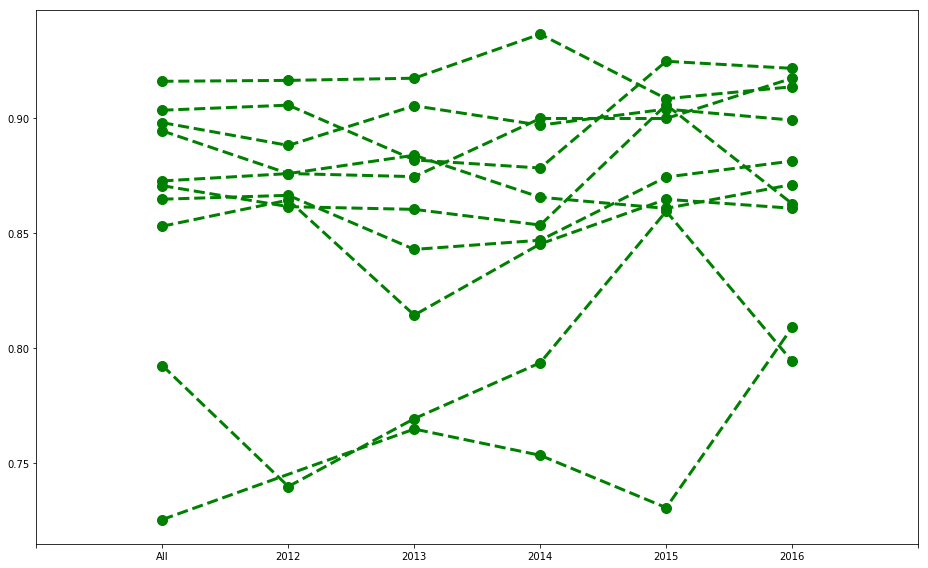


Plotting School of Medicine


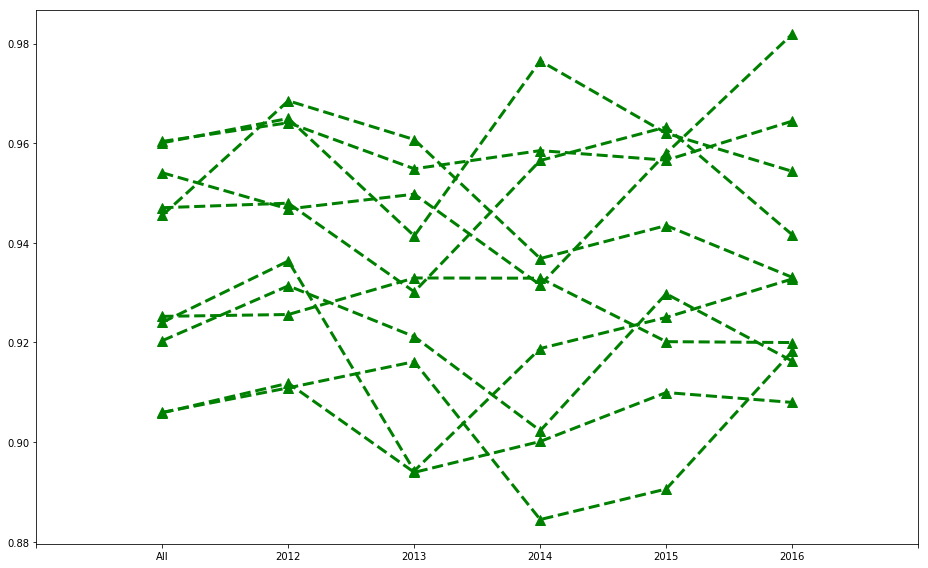


Plotting Institutes and Provost's Academic Units


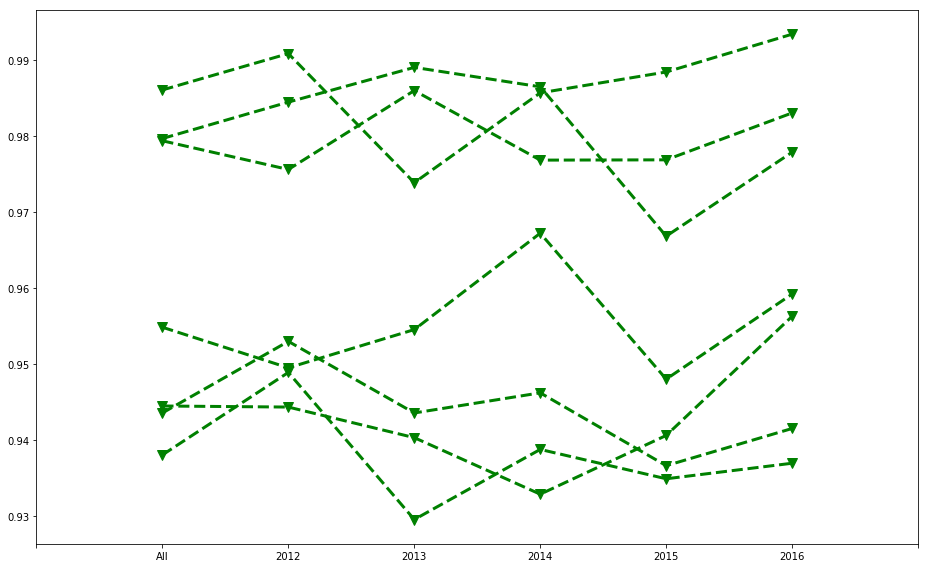


Plotting Other


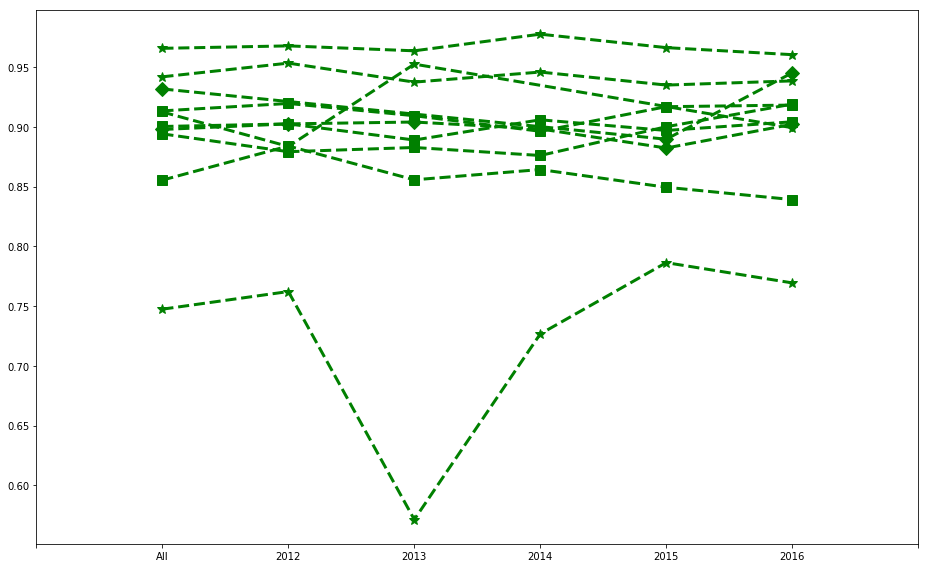

In [32]:
for school in schools_to_plot+['Other']:
    print "\nPlotting %s" % school

    if school != 'Other':
        df_school = df_fracs[(df_fracs.school_name == school)]
    else:
        df_school = df_fracs
        for school2 in schools_to_plot:
            df_school = df_school[(df_school.school_name != school2)]

    if df_school.empty: print "No rows in df_school, continuing!"; continue;

    # Find orgs to plot
    df_school_all = df_school[(df_school.year == -1)]
    if df_school_all.empty: print "No rows in df_school_all, continuing!"; continue;
    
    orgs_to_plot = df_school_all.nlargest(top_n_orgs_to_plot, 'node_total_weight').org_name.unique()

    fig = plt.figure("frac plot "+school)
    fig.set_size_inches(13, 8) # x, y inches
    ax = plt.subplot(111)
    
    all_years_value = sorted(year_ints)[1]-1

    for norg in range(len(orgs_to_plot)):
        org = orgs_to_plot[norg]
        df_school_org = df_school[(df_school.org_name == org)]

        real_schools = df_school_org.school_name.unique()
        if len(real_schools) > 1:
            print "ERROR: Multiple real_schools, continuing!"
            continue

        real_school = real_schools[0]

        yaxis_values = []
        xaxis_values = []
        for year in year_ints:
            df_school_org_year = df_school_org[(df_school_org.year == year)]
            # this is just the row we wanted
            if df_school_org_year.empty:
                # print "Empty df_school_org_year, continuing!"
                continue
            elif len(df_school_org_year.index)!=1:
                print "> 1 rows in df_school_org_year - something is wrong! Continuing!"
                continue
            else:
                yaxis_values.append(df_school_org_year.interdis_frac.iloc[0])
                if year != -1:
                    xaxis_values.append(year)
                else:
                    xaxis_values.append(all_years_value)

            # print df_school_org_year[['year','interdis_frac','org_name','node_total_weight','cut','node_weight_iqr']]

        #print org
        #for n in range(len(xaxis_values)): print "%s, %d, %.4f" % (xaxis_ticks[n], xaxis_values[n], yaxis_values[n])

        ax.plot(xaxis_values,yaxis_values,
                label=org,
                color='green',
                linestyle='dashed',
                marker=visJS_to_mpl_symbol[school_symbols[real_school]],
                linewidth=3,
                markersize=10)

    # org_leg = plt.legend(leg_objects, [ob.get_label() for ob in leg_objects], fontsize='large', borderaxespad=0.0)
    # org_leg.get_frame().set_edgecolor('white')
    # org_leg.get_frame().set_facecolor('white')

    # Clean up x axis ticks
    ticklocs = ax.xaxis.get_ticklocs()
    tickmin = min(ticklocs)
    tickmax = max(ticklocs)    
    ticklabels = []
    for tick in list(ticklocs):
        if tick == all_years_value: ticklabels.append('All')
        elif tick == tickmin or tick == tickmax: ticklabels.append('')
        else: ticklabels.append('%d' % tick)
    plt.xticks(ticklocs, ticklabels)

    fig.tight_layout()
    # make_path(m_path)
    # fig.savefig(m_path+'/'+filename+'.pdf', format="pdf")
    plt.show()
    fig.clf()